In [15]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [16]:
# Load the VGG16 model without the top (fully connected) layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [17]:
# Freeze the layers of VGG16 to retain learned features
for layer in base_model.layers:
    layer.trainable = False

In [18]:
# Build a new model with custom layers on top of VGG16
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])

In [19]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    # Added brightnes variation
    brightness_range=[0.5,1.5]
)

In [21]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [22]:
# Load train and validation data
train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(224, 224),
    batch_size=5,
    class_mode='binary'
)

Found 30 images belonging to 2 classes.


In [23]:
validation_generator = val_datagen.flow_from_directory(
    'dataset/validation',
    target_size=(224, 224),
    batch_size=5,
    class_mode='binary'
)

print(f"Number of training samples: {train_generator.samples}")
print(f"Batch size: {train_generator.batch_size}")
print(f"Steps would be: {train_generator.samples // train_generator.batch_size}")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)

Found 10 images belonging to 2 classes.


Number of training samples: 30
Batch size: 5
Steps would be: 6
Epoch 1/10
6/6 [==============================] - 13s 2s/step - loss: 1.1529 - accuracy: 0.3667 - val_loss: 0.6897 - val_accuracy: 0.5000
Epoch 2/10
6/6 [==============================] - 10s 2s/step - loss: 0.7261 - accuracy: 0.6000 - val_loss: 0.6649 - val_accuracy: 0.5000
Epoch 3/10
6/6 [==============================] - 10s 2s/step - loss: 0.6041 - accuracy: 0.7000 - val_loss: 0.5776 - val_accuracy: 0.5000
Epoch 4/10
6/6 [==============================] - 10s 2s/step - loss: 0.5950 - accuracy: 0.7333 - val_loss: 0.4632 - val_accuracy: 1.0000
Epoch 5/10
6/6 [==============================] - 11s 2s/step - loss: 0.4786 - accuracy: 0.9000 - val_loss: 0.3812 - val_accuracy: 0.9000
Epoch 6/10
6/6 [==============================] - 10s 2s/step - loss: 0.5039 - accuracy: 0.7333 - val_loss: 0.2522 - val_accuracy: 1.0000
Epoch 7/10
6/6 [==============================] - 10s 2s/step - loss: 0.5017 - accuracy: 0.8000 - val_loss: 0

In [24]:
# Unfreeze the last few layers of the VGG16 model
for layer in base_model.layers[-4:]:
    layer.trainable = True

In [25]:
# Re-compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
# Continue training (fine-tuning)
history_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=5
)

Epoch 1/5
6/6 [==============================] - 17s 2s/step - loss: 0.1741 - accuracy: 0.9667 - val_loss: 0.0943 - val_accuracy: 1.0000
Epoch 2/5
6/6 [==============================] - 12s 2s/step - loss: 0.1780 - accuracy: 0.9000 - val_loss: 0.1030 - val_accuracy: 1.0000
Epoch 3/5
6/6 [==============================] - 12s 2s/step - loss: 0.1162 - accuracy: 0.9667 - val_loss: 0.0381 - val_accuracy: 1.0000
Epoch 4/5
6/6 [==============================] - 12s 2s/step - loss: 0.1168 - accuracy: 0.9667 - val_loss: 0.0412 - val_accuracy: 1.0000
Epoch 5/5
6/6 [==============================] - 13s 2s/step - loss: 0.0707 - accuracy: 1.0000 - val_loss: 0.0559 - val_accuracy: 1.0000


In [27]:
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

2/2 [==============================] - 3s 1s/step - loss: 0.0559 - accuracy: 1.0000
Validation Accuracy: 100.00%


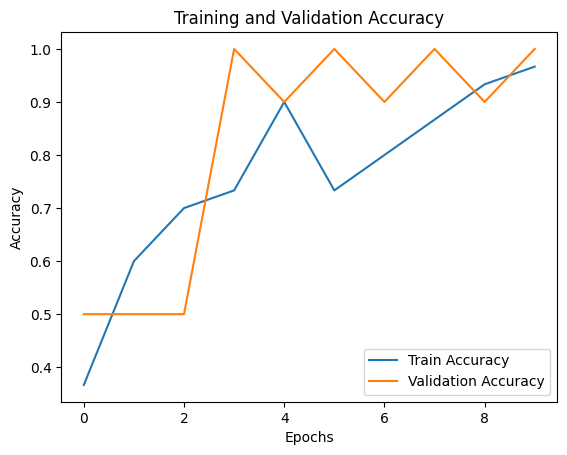

In [28]:
# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()